# Variational Inference

## 0. Initialize

In [1]:
#mathematics
using LinearAlgebra
using SpecialFunctions

#statistics
using Random
using Statistics
using Distributions

#visualize
using Plots
pyplot()

#macros
using ProgressMeter
using UnPack

## 1. mean field approximation

In [2]:
#ELBO
ELBO(X, SN, SsqN, β, μhat, λhat, αhat, βhat) = (-log(λhat)/2+1/λhat/2-αhat*log(βhat)+
    log(gamma(αhat))-(αhat-1)*(digamma(αhat)-log(βhat))+αhat 
    + N*(digamma(αhat)-log(2*pi*βhat))/2-αhat*(SsqN-2*μhat*SN+N*μhat^2+N/λhat)/βhat/2-(μhat^2+1/λhat)/2
    + log(β)-β*αhat/βhat)

#variational inference using mean field approximation
function myVI(data, model_params, inits, n_train, tol)
    @unpack X,N = data
    @unpack β = model_params
    @unpack μhat₀, λhat₀, βhat₀ = inits
    SN = sum(X)
    SsqN = sum(X.^2)
    μhat = μhat₀
    λhat = λhat₀
    αhat = N/2+1
    βhat = βhat₀
    Lvec = zeros(n_train+1)
    Lvec[1] = ELBO(X, SN, SsqN, β, μhat, λhat, αhat, βhat)
    
    @showprogress for k in 1:n_train
        λhat = 1 + N*αhat/βhat
        μhat = SN * αhat/λhat/βhat
        βhat = β + SsqN/2 - μhat*SN + N*μhat^2/2 + N/λhat/2
        Lvec[k+1] = ELBO(X, SN, SsqN, β, μhat, λhat, αhat, βhat)
        if abs(Lvec[k+1]-Lvec[k])<tol
            return μhat, λhat, αhat, βhat, Lvec[1:k+1]
            break
        end
    end
    return μhat, λhat, αhat, βhat, Lvec
end

#variational posterior sample
function post_samps(var_prams, n_samps)
    μsamps = rand(Normal(μhat, 1/√λhat), n_samps)
    λsamps = rand(Gamma(αhat, 1/βhat), n_samps)
    return μsamps, λsamps
end

#predictive distribution
function pred(x, samps)
    @unpack μsamps, λsamps = samps
    n_samps = length(μsamps)
    preds = zeros(n_samps)
    for s in 1:n_samps
        preds[s] = pdf(Normal(μsamps[s], 1/√λsamps[s]),x)
    end 
    return mean(preds)
end

#Gibbs sampler for comparing the posterior to variational posterior
function myGibbs(data, model_params, inits, n_samps, n_burnin)
    @unpack X,N = data
    @unpack β = model_params
    @unpack μ₀,λ₀ = inits
    SN = sum(X)
    μsamps = zeros(n_samps)
    λsamps = zeros(n_samps)
    μsamps[1] = μ₀
    λsamps[1] = λ₀
    @showprogress for s in 2:n_samps
        μsamps[s] = rand(Normal(λsamps[s-1]*SN/(λsamps[s-1]*N+1), 1/√(λsamps[s-1]*N+1)))
        λsamps[s] = rand(Gamma(N/2+1, 1/(β+sum((X.-μsamps[s-1]).^2)/2)))
    end
    return μsamps[n_burnin:end], λsamps[n_burnin:end]
end

myGibbs (generic function with 1 method)

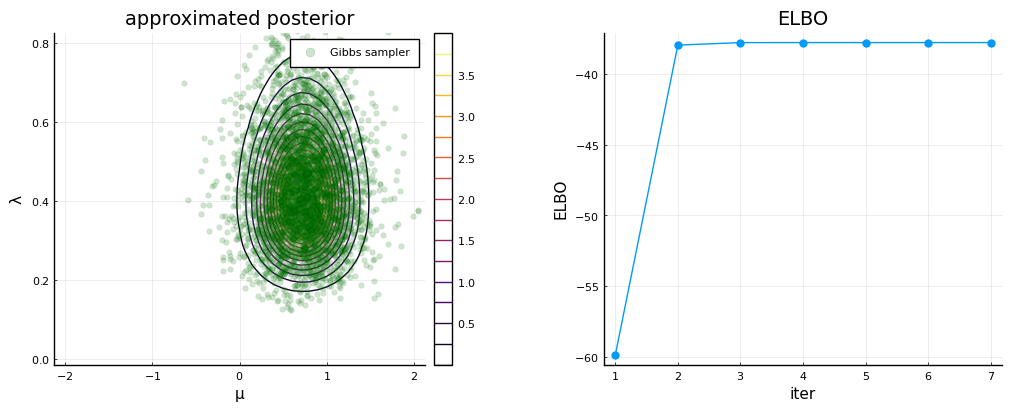

In [3]:
#create data
μ₁ = -1.4
μ₂ = 1.5
σ₁ = 1.1
σ₂ = 0.9
N = 20
mixture_normal = MixtureModel([Normal(μ₁, σ₁), Normal(μ₂, σ₂)])
true_pdf(x) = pdf(mixture_normal, x)
X = rand(mixture_normal, N)
data = (X=X, N=N)

#set the seed
Random.seed!(42)

#variational inference
β = 1e1
model_params = (β=β,)
inits = (μhat₀=0.0 , λhat₀=1.0, βhat₀=β)
n_train = 1000
tol = 1e-6
μhat, λhat, αhat, βhat, Lvec = myVI(data, model_params, inits, n_train, tol)
var_params = (μhat=μhat, λhat=λhat, αhat=αhat, βhat=βhat)

#approximated posterior pdf
function r(μ, λ, var_params)
    @unpack μhat,λhat,αhat,βhat = var_params
    return exp(logpdf(Normal(μhat, 1/√λhat), μ) + logpdf(Gamma(αhat, 1/βhat), λ))
end

#Gibbs sampler
n_samps = 5000
n_burnin = div(n_samps, 10)
inits = (μ₀=0.0, λ₀=1.0)
μsamps, λsamps = myGibbs(data, model_params, inits, n_samps, n_burnin)
samps = (μsamps=μsamps, λsamps=λsamps)

#visualize the variational and true posterior
p1 = plot(-2:0.1:2, 0.01:0.01:0.8, (μ,λ)->r(μ,λ,var_params), st=:contour, xlabel="μ", ylabel="λ", title="approximated posterior", xlim=[-2,2], ylim=[0.01, 0.8])
plot!(μsamps, λsamps, st=:scatter, alpha=0.2, label="Gibbs sampler", markerstrokewidth=0.2, color=:green)
p2 = plot(Lvec, title="ELBO", xlabel="iter", ylabel="ELBO", label=false, marker=:circle, markerstrokewidth=0, markersize=6)
fig1 = plot(p1, p2, size=(1000, 400))
savefig(fig1, "figs-VI/fig1.png")

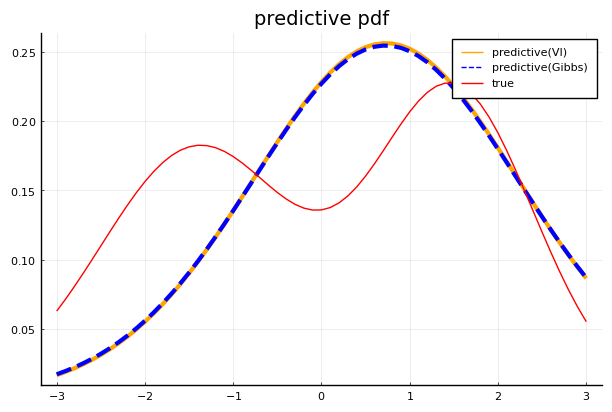

In [4]:
#variational prediction
n_samps = 5000
μsamps_var, λsamps_var = post_samps(var_params, n_samps)
var_samps = (μsamps=μsamps_var, λsamps=λsamps_var)

#visualize the predictive pdf
xs = -3:0.1:3
fig2 = plot(xs, x->pred(x,var_samps), color=:orange, ls=:solid, lw=3, label="predictive(VI)")
plot!(xs, x->pred(x,samps), color=:blue, ls=:dash, lw=3,label="predictive(Gibbs)")
plot!(xs, true_pdf, label="true", title="predictive pdf", color=:red)
savefig(fig2, "figs-VI/fig2.png")

## 2. designate the variational distirbution

In [5]:
#plot the data and return the figure
function plot_data(X, Y)
    _,N = size(X)
    fig = plot(xticks=0:0.2:1, xlim=[0,1], yticks=0:0.2:1, ylim=[0,1], aspect_ratio=:equal, title="data", legend=false)
    for k in 1:N
        if Y[k]==1
            plot!([X[1,k]], [X[2,k]], st=:scatter, markershape=:circle, markersize=10, color="red")
        else
            plot!([X[1,k]], [X[2,k]], st=:scatter, markershape=:x, markersize=10, color="blue")
        end
    end
    return fig
end

function plot_data(fig, X, Y)
    _,N = size(X)
    fig = plot!(xticks=0:0.2:1, xlim=[0,1], yticks=0:0.2:1, ylim=[0,1], aspect_ratio=:equal, legend=false)
    for k in 1:N
        if Y[k]==1
            plot!([X[1,k]], [X[2,k]], st=:scatter, markershape=:circle, markersize=10, color="red")
        else
            plot!([X[1,k]], [X[2,k]], st=:scatter, markershape=:x, markersize=10, color="blue")
        end
    end
    return fig
end

#initialize the parameter
function init_params(st)
    @unpack  Dx, Dy, D₀ = st
    W₂ = rand(D₀, Dx)
    W₃ = rand(Dy, D₀)
    b₂ = zeros(D₀)
    b₃ = zeros(Dy)
    return W₂, W₃, b₂, b₃
end

#stick the weights and biases to a large matrix
function stick_params(W₂, W₃, b₂, b₃, Dx)
    tmp1 = vcat(b₂', W₂')
    tmp2 = hcat(tmp1, zeros(Dx+1))
    tmp3 = hcat(W₃, b₃)
    return vcat(tmp2, tmp3)
end

#devide the paramters vector to weights and biases
function reshape_params(wvec, st)
    @unpack  Dx, Dy, D₀ = st
    W = reshape(wvec, (Dx+Dy+1, D₀+1))
    W₂ = view(W, 2:Dx+1, 1:D₀)'
    W₃ = view(W, Dx+2:Dx+Dy+1, 1:D₀)
    b₂ = view(W, 1, 1:D₀)
    b₃ = view(W, Dx+2:Dx+Dy+1, D₀+1)
    return W₂, W₃, b₂, b₃
end 

#sigmoid function
σ(ξ) = 1/(1+exp(-ξ)) 

#Neural Network
function nn(x, wvec, st)
    W₂, W₃, b₂, b₃ = reshape_params(wvec, st)
    return σ.(W₃*σ.(W₂*x+b₂) + b₃)
end

#log pdf of prior, model, posterior
logpprior(wvec, λ, dw) = logpdf(MvNormal(zeros(dw),1/sqrt(λ)), wvec)
logpmodel(y, x, wvec, st) = logpdf(Bernoulli(nn(x,wvec,st)[1]), y)
loglik(X, Y, N, wvec, st) = sum([logpmodel(Y[n], X[:,n], wvec, st) for n in 1:N])

function logppost(wvec, data, model_params)
    @unpack X,Y,N = data
    @unpack λw,dw,st = model_params
    return loglik(X, Y, N, wvec, st) + logpprior(wvec, λw, dw)
end

function logppost(wvec, λw, data, model_params)
    @unpack X,Y,N = data
    @unpack dw,st = model_params
    return loglik(X, Y, N, wvec, st) + logpprior(wvec, λw, dw)
end

#predictive: returns the probability to new data classified to class 1
function ppred(x, wsamps, st)
    _, n_samps = size(wsamps)
    preds = zeros(n_samps)
    for j in 1:n_samps
        preds[j] = exp(logpmodel(1, x, wsamps[:,j], st))
    end
    return mean(preds)
end

#∇θLn(θ)
function ∇θLn(x, y, N, wsamps, θvec, λw, st)
    dw,S = size(wsamps)
    centwvec = wsamps-θvec[1:dw]*ones(S)'
    logpmodels = zeros(S)
    for s in 1:S
        logpmodels[s] = logpmodel(y, x, wsamps[:,s], st)
    end
    arr1 = centwvec .* (ones(dw)*logpmodels')
    arr2 = centwvec .* arr1
    ∇θLnvec = zeros(2*dw)
    for j in 1:dw
        ∇θLnvec[j] = N*exp(-2*θvec[dw+j])*mean(arr1[j,:])-λw*θvec[j]
        ∇θLnvec[dw+j] = N*exp(-2*θvec[dw+j])*mean(arr2[j,:])-N*mean(logpmodels)+1-λw*exp(2*θvec[dw+j])
    end
    return ∇θLnvec
end

#calculate ELBO
function ELBO(X, Y, N, wsamps, θvec, λw, st)
    dw,S = size(wsamps)
    logpmodels = zeros(S)
    for s in 1:S
        for n in 1:N
            logpmodels[s] += logpmodel(Y[n], X[:,n], wsamps[:,s], st)
        end
    end
    return mean(logpmodels)-λw*sum(θvec[1:dw].^2)/2-λw*sum(exp.(2*θvec[dw+1:end]))/2+sum(θvec[dw+1:end])+dw/2+dw*log(λw)/2
end

#sample from approximation distribution r
post_samps(θvec, n_samps, dw) = rand(MvNormal(θvec[1:dw], exp.(θvec[dw+1:2*dw])), n_samps)

#variational inference
function myVI(data, model_params, α, n_train, tol)
    @unpack X,Y,N = data
    @unpack λw, dw, st = model_params
    θvec = vcat(zeros(dw), ones(dw))
    n_samps = 5000
    wsamps = zeros(dw, n_samps)
    history = zeros(n_train)
    history[1] = ELBO(X, Y, N, wsamps, θvec, λw, st)
    @showprogress for k in 2:n_train
        idx = rand(1:N)
        x = X[:,idx]
        y = Y[idx]
        wsamps = post_samps(θvec, n_samps, dw)
        θvec = θvec + α*∇θLn(x, y, N, wsamps, θvec, λw, st)/k
        history[k] = ELBO(X, Y, N, wsamps, θvec, λw, st)
        if abs(history[k]-history[k-1])<tol
            return θvec, history[2:k]
        end
    end
    return θvec, history
end

myVI (generic function with 1 method)

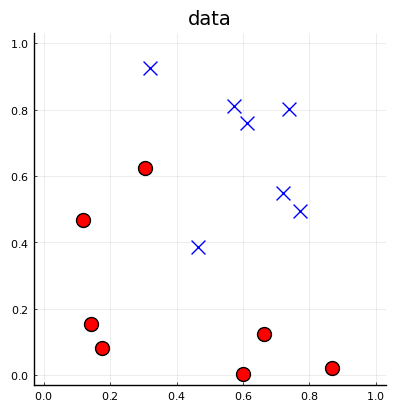

In [6]:
#create the data
Random.seed!(46)
N = 14
X = hcat(rand(Beta(1.1,3), 2, div(N,2)), rand(Beta(1.9,1.1), 2, div(N,2)))
Y = vcat(ones(div(N,2)), zeros(div(N,2)))
data = (X=X,Y=Y,N=N)

#size
Random.seed!(42)
Dx,N = size(X)
Dy = 1
D₀ = 5
st = (Dx=Dx, Dy=Dy, D₀=D₀)

#plot the data
fig3 = plot_data(X, Y)
savefig(fig3, "figs-VI/fig3.png")

Progress: 100%|█████████████████████████████████████████| Time: 0:01:07


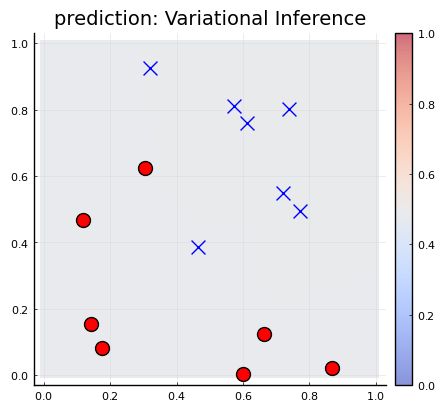

In [7]:
#initialize NN
W₂, W₃, b₂, b₃ = init_params(st)
Ws = stick_params(W₂, W₃, b₂, b₃, st.Dx)
wvec₀ = Ws[:]
dw = length(wvec₀)

#model params
λw = 1e-3
model_params = (λw=λw, dw=dw, st=st)

#calculate the variational parameters
α = 0.3
tol = 1e-6
n_train = 1000
θvec, history = myVI(data, model_params, α, n_train, tol)

#posterior sample
n_samps = 5000
wsamps = post_samps(θvec, n_samps, dw)

#calculate and visualize predictive
fig4 = plot(0:0.02:1, 0:0.02:1, (x1,x2)->ppred([x1,x2], wsamps, st), st=:heatmap, c=cgrad(:coolwarm), alpha=0.6, clim=(0,1))
fig4 = plot_data(fig4, X, Y)
plot!(title="prediction: Variational Inference")
savefig(fig4, "figs-VI/fig4.png")

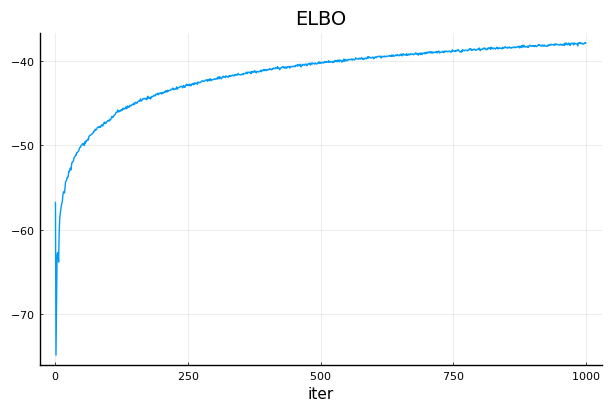

In [8]:
fig5 = plot(history, xlabel="iter", title="ELBO", label=false)
savefig(fig5, "figs-VI/fig5.png")